### TODO
1. Setup three models for GOBench dataset
2. Setup three models for DGP dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, json
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

def get_sparse_probs(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_ids"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(device)
            m_probs = model(X)
            torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(new_probs)
    probs = vstack(probs_list)
    return prot_ids, probs

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support
def threshold_stats(testing_matrix, prediction_matrix):
    precs = []
    recs = []
    f_scores = []
    rms = []
    for threshold in np.linspace(0.001, 1, 100):
        preds = prediction_matrix.copy()
        preds.data = np.where(preds.data >= threshold, 1, 0)
        preds.eliminate_zeros()
        p, r, f, support = precision_recall_fscore_support(testing_matrix, preds, average='micro')
        precs.append(p)
        recs.append(r)
        f_scores.append(f)
        rms.append(r*r * preds.shape[0] * preds.shape[1] / preds.sum())
    return precs, recs, f_scores, rms
    
# prot_ids, probs = get_sparse_probs(m, train_loader)

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BLAST Utility Functions

In [21]:
def load_diamond_scores(hit_fn):
    diamond_scores = {}
    with open(hit_fn) as f:
        for line in f:
            it = line.strip().split()
            if it[0] not in diamond_scores:
                diamond_scores[it[0]] = {}
            diamond_scores[it[0]][it[1]] = float(it[2])
    return diamond_scores

def blast_hit_to_pred(train_dict, diamond_scores, pred_ids):
    blast_preds = {}
    for prot_id in pred_ids:
        annots = {}
        if(prot_id in diamond_scores):
            sim_prots = diamond_scores[prot_id] #Similar prots in training
            allgos = set()
            total_score = 0.0
            for pid, score in sim_prots.items():
                allgos |= set(train_dict[pid]) #GO Terms for each similar prot
                total_score += score
            allgos = list(sorted(allgos))
            sim = np.zeros(len(allgos), dtype=np.float32)
            for j, go_id in enumerate(allgos):
                s = 0.0
                for p_id, score in sim_prots.items():
                    if go_id in train_dict[p_id]:
                        s += score
                sim[j] = s / total_score
            for go_id, score in zip(allgos, sim):
                annots[go_id] = score
        blast_preds[prot_id] = annots
    return blast_preds

from scipy.sparse import csr_matrix, dok_matrix, lil_matrix
def score_dict_to_sparse_matrix(protein_annotation_dict, term_list, prot_id_list):
    term_col_mappings = {term:i for i, term in enumerate(term_list)}
    prot_row_mappings = {prot:i for i, prot in enumerate(prot_id_list)}

    labels = lil_matrix((len(prot_id_list), len(term_list)), dtype=np.float64)

    for row, prot_id in enumerate(prot_id_list):
        if(prot_id in protein_annotation_dict):
            for go_id, score in protein_annotation_dict[prot_id].items():
                if(go_id in term_col_mappings):
                    labels[row, term_col_mappings[go_id]] = score
    labels = labels.tocsr()
    return labels

from collections import defaultdict
def sparse_matrix_to_score_dict(pred_matrix, term_list, prot_id_list):
    protein_annotation_dict = defaultdict(dict)
    for row, prot_id in enumerate(prot_id_list):
        pr = pred_matrix[row]
        for go_index, score in zip(pr.indices, pr.data):
            protein_annotation_dict[prot_id][term_list[go_index]] = score
    return protein_annotation_dict


In [71]:
vm = val_blast_preds_matrix
vd = sparse_matrix_to_score_dict(vm, go_terms, val_ids)
vm2 = score_dict_to_sparse_matrix(vd, go_terms, val_ids)

vmtest = score_dict_to_sparse_matrix(vd, test_go_terms, val_ids)
vdtest = sparse_matrix_to_score_dict(vm, go_terms, val_ids)
vm3 = score_dict_to_sparse_matrix(vdtest, go_terms, val_ids)

print((vm3 != vm).sum())
print(vmtest.shape, vm3.shape)


0


In [5]:
def load_annot_matrix(term_path, annot_path, seq_path):
    with open(term_path, 'r') as f:
        go_terms = json.load(f)
    annot_dict = load_GO_tsv_file(annot_path)
    dict_ids = list(annot_dict.keys())
    annot_seqs, annot_ids = load_protein_sequences(seq_path, set(dict_ids))
    annot_mat = convert_to_sparse_matrix(annot_dict, go_terms, annot_ids)
    return go_terms, annot_ids, annot_seqs, annot_mat

In [6]:
go_terms, train_ids, _, train_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/training_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

In [7]:
print(len(go_terms), len(train_ids), (train_labels).shape)
print(go_terms[:10])

865 77665 (77665, 865)
['GO:0003674', 'GO:0005488', 'GO:0003824', 'GO:0005515', 'GO:0097159', 'GO:1901363', 'GO:0016740', 'GO:0003676', 'GO:0016787', 'GO:0140096']


In [7]:
print(train_ids[0])

Q9XHP0


In [8]:
print('GO:0017056' in go_terms)

True


# GOBench Benchmarks

In [22]:
go_terms, train_ids, _, train_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/training_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

_, val_ids, _, val_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/validation_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

test_go_terms, test_ids, _, test_labels = load_annot_matrix("data/go_bench/testing_molecular_function_terms.json", 
                                                        "data/go_bench/testing_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

train_dict = load_GO_tsv_file("data/go_bench/training_molecular_function_annotations.tsv")
val_dict = load_GO_tsv_file("data/go_bench/validation_molecular_function_annotations.tsv")
test_dict = load_GO_tsv_file("data/go_bench/testing_molecular_function_annotations.tsv")

diamond_scores = load_diamond_scores("data/blast_results/blast_hit_val.tsv")
test_diamond_scores = load_diamond_scores("data/blast_results/blast_hit_test.tsv")

val_blast_preds = blast_hit_to_pred(train_dict, diamond_scores, val_ids)
test_blast_preds = blast_hit_to_pred(train_dict, test_diamond_scores, test_ids)

val_blast_preds_matrix = score_dict_to_sparse_matrix(val_blast_preds, go_terms, val_ids)
test_blast_preds_matrix = score_dict_to_sparse_matrix(test_blast_preds, test_go_terms, test_ids)

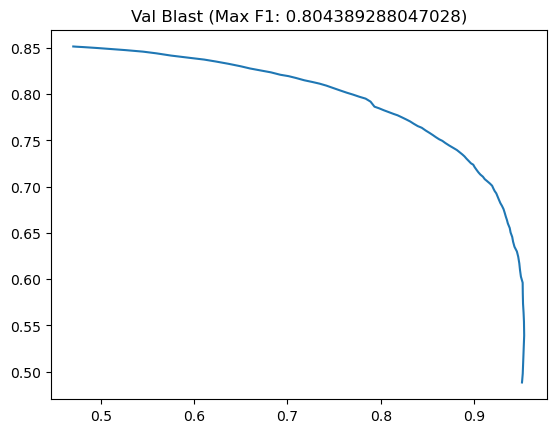

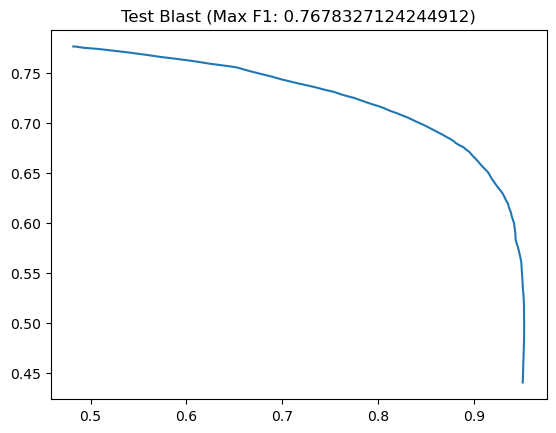

In [10]:
blast_precs, blast_recs, f_scores, rms = threshold_stats(val_labels, val_blast_preds_matrix)
plt.plot(blast_precs, blast_recs)
plt.title(f"Val Blast (Max F1: {max(f_scores)})")
plt.show()

precs, recs, f_scores, rms = threshold_stats(test_labels, test_blast_preds_matrix)
plt.plot(precs, recs)
plt.title(f"Test Blast (Max F1: {max(f_scores)})")
plt.show()

In [23]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
train_path = "/home/andrew/go_metric/data/go_bench"

train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
# test_dataset = BertSeqDataset.from_memory("data/go_bench/testing_molecular_function_annotations.tsv", 
#                                             "data/go_bench/testing_molecular_function_terms.json", 
#                                             "data/uniprot_reviewed.fasta")
# test_dataset.to_pickle(f"{train_path}/test.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 256, "collate_fn":collate_seqs}
train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params, num_workers=6)
test_loader = DataLoader(test_dataset, **val_dataloader_params, num_workers=6)


In [12]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/bottleneck_128.ckpt")
model.eval()
device = torch.device('cuda:1')
model.to(device)

test_ids, test_probs = get_sparse_probs(model, test_loader)
val_ids, val_probs = get_sparse_probs(model, val_loader)


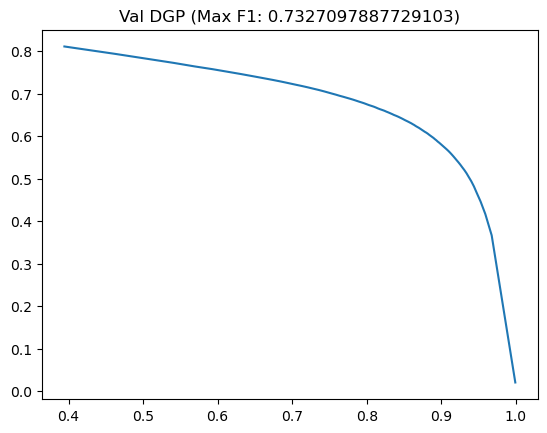

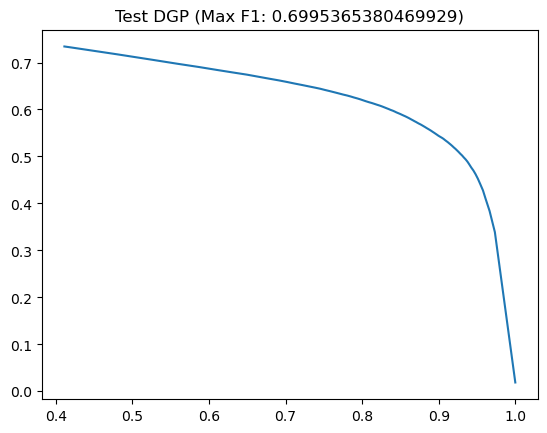

In [14]:
precs, recs, f_scores, rms = threshold_stats(val_labels, val_probs)
plt.plot(precs, recs)
plt.title(f"Val DGP (Max F1: {max(f_scores)})")
plt.show()

probs_d = sparse_matrix_to_score_dict(test_probs, go_terms, test_ids)
probs_tm = score_dict_to_sparse_matrix(probs_d, test_go_terms, test_ids)
precs, recs, f_scores, rms = threshold_stats(test_labels, probs_tm)
plt.plot(precs, recs)
plt.title(f"Test DGP (Max F1: {max(f_scores)})")
plt.show()

# Bottleneck 2048

In [ ]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/bottleneck_128.ckpt")
model.eval()
device = torch.device('cuda:1')
model.to(device)

test_ids, test_probs = get_sparse_probs(model, test_loader)
val_ids, val_probs = get_sparse_probs(model, val_loader)

precs, recs, f_scores, rms = threshold_stats(val_labels, val_probs)
plt.plot(precs, recs)
plt.title(f"Val DGP (Max F1: {max(f_scores)})")
plt.show()

probs_d = sparse_matrix_to_score_dict(test_probs, go_terms, test_ids)
probs_tm = score_dict_to_sparse_matrix(probs_d, test_go_terms, test_ids)
precs, recs, f_scores, rms = threshold_stats(test_labels, probs_tm)
plt.plot(precs, recs)
plt.title(f"Test DGP (Max F1: {max(f_scores)})")
plt.show()

In [ ]:
from go_metric.models.bert_emb import ProtBertBFDClassifier
import pickle 
with open("checkpoints/bert_emb_hparams.pkl", "rb") as f:
    hparams = pickle.load(f)
    hparams.num_classes = 865
model = ProtBertBFDClassifier.load_from_checkpoint("checkpoints/bert_emb.ckpt", hparams=hparams)
model.eval()
device = torch.device('cuda:1')
model.to(device)

In [24]:
collate_seqs = get_bert_seq_collator(max_length=hparams.max_length, add_special_tokens=True)
dataloader_params = {"shuffle": True, "batch_size": 12, "collate_fn":collate_seqs}
val_dataloader_params = {"shuffle": False, "batch_size": 24, "collate_fn":collate_seqs}

train_loader = DataLoader(train_dataset, **dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params)
test_loader = DataLoader(test_dataset, **val_dataloader_params)

In [29]:
def get_sparse_probs_bert(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_ids"]
            inputs, mask, y = d['seq'].to(device), d['mask'].to(device), d['labels'].to(device)
            prot_ids.extend(prot_id_l)
            m_probs = model.forward(inputs, None, mask)
            torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(new_probs)
    probs = vstack(probs_list)
    return prot_ids, probs

test_ids, test_probs = get_sparse_probs_bert(model, test_loader)
val_ids, val_probs = get_sparse_probs_bert(model, val_loader)

KeyboardInterrupt: 

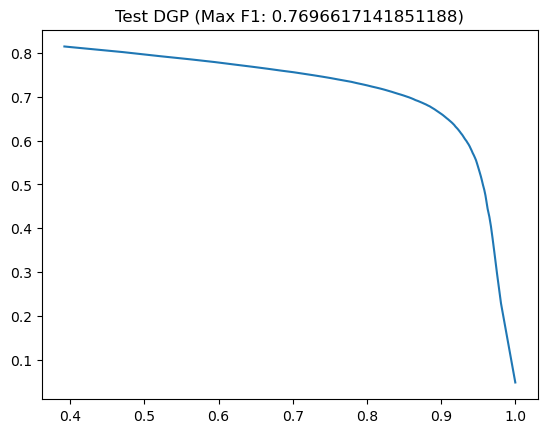

In [30]:
# precs, recs, f_scores, rms = threshold_stats(val_labels, val_probs)
# plt.plot(precs, recs)
# plt.title(f"Val DGP (Max F1: {max(f_scores)})")
# plt.show()

probs_d = sparse_matrix_to_score_dict(test_probs, go_terms, test_ids)
probs_tm = score_dict_to_sparse_matrix(probs_d, test_go_terms, test_ids)
precs, recs, f_scores, rms = threshold_stats(test_labels, probs_tm)
plt.plot(precs, recs)
plt.title(f"Test DGP (Max F1: {max(f_scores)})")
plt.show()

# DGP Results

In [41]:
train_dataset = BertSeqDataset.from_dgp_pickle("/home/andrew/go_metric/dgp_data/data/terms.pkl", 
                                                "/home/andrew/go_metric/dgp_data/data/train_data.pkl")
test_dataset = BertSeqDataset.from_dgp_pickle("/home/andrew/go_metric/dgp_data/data/terms.pkl", 
                                                "/home/andrew/go_metric/dgp_data/data/test_data.pkl")

collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 64, "collate_fn":collate_seqs}

train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
test_loader = DataLoader(test_dataset, **val_dataloader_params, num_workers=6)
import pickle
with open("/home/andrew/go_metric/dgp_data/data/terms.pkl", 'rb') as f:
    terms = pickle.load(f)
    terms = terms['terms'].to_list()

In [47]:
diamond_scores = load_diamond_scores("dgp_data/data/test_diamond.res")

In [48]:
print(len(train_dataset), len(test_dataset))
print((np.array(train_dataset.labels.sum(axis=0)) > 50).sum())

74541 3924
5626


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,
         24.,  85., 126., 119., 121., 127., 115., 111.,  92.,  97.,  97.,
         81.,  93.,  78.,  86.,  66.,  70.,  61.,  60.,  60.,  52.,  50.,
         67.,  54.,  53.,  53.,  44.,  40.,  46.,  33.,  40.,  48.,  41.,
         44.,  49.,  33.,  40.,  36.,  29.,  42.,  62.,  34.,  19.,  37.,
         17.,  24.,  31.,  38.,  25.,  21.,  31.,  36.,  27.,  30.,  33.,
         16.,  17.,  17.,  29.,  16.,  16.,  17.,  16.,  15.,  16.,  23.,
         22.,  11.,  12.,  22.,  16.,  13.,  19.,  17.,  16.,  13.,  20.,
         24.,  20.,  18.,  12.,  17.,  13.,  16.,  10.,   9.,  17.,  17.,
         13.,  20.,  18.,  14.,  17.,  18.,  14.,  13.,   9.,  10.,  16.,
         13.,  19.,  13.]),
 array([  0.        ,   2.01612903,   4.03225806,   6.0483871 ,
          8.06451613,  10.08064516,  12.09677419,  14.11290323,
         16.12903226,  18.1451

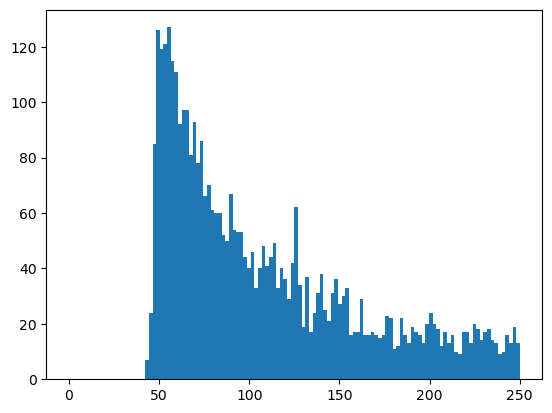

In [40]:
plt.hist(np.array(train_dataset.labels.sum(axis=0)).flatten(), bins=np.linspace(0, 250, 125))

In [25]:
print(train_dataset.labels.shape)
print(len(terms))

(74541, 5868)
5868


# Similarity Search

# Classify proteins with model
# Identify most similar proteins that support prediction in database


In [24]:
def get_embeddings(model, dataloader, device):
    prot_ids = []
    embed_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_ids"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(device)
            embed = model.embedding(X)
            embed_list.append(embed)
    embeddings = torch.cat(embed_list, dim=0)
    return prot_ids, embeddings

In [31]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/bottleneck_128.ckpt")
model.eval()
device = torch.device('cuda:1')
model.to(device)

_, train_emb = get_embeddings(model.model, train_loader, device)
_, val_emb = get_embeddings(model.model, val_loader, device)

In [15]:
import numpy as np
from scipy.sparse import csc_matrix

In [40]:
db_labels = csc_matrix(train_labels)
db_id, q_id = train_ids, val_ids
db_emb, q_emb = train_emb.cpu().numpy(), val_emb.cpu().numpy()

In [43]:
q_emb = q_emb[0, :]
db_dists = np.linalg.norm(db_emb - q_emb, axis=1)

In [44]:
val_ids, val_probs = get_sparse_probs(model, val_loader)

In [49]:
model_pred = val_probs[0, :].toarray()
terms = go_terms

In [54]:
db_sl = db_labels[:, pind].nonzero()[0]
q_pid = q_id[0]

In [61]:
model_cls = model_pred > 0.5
nz = model_cls.nonzero()[1]
pf_map = {}
for pind in nz:
    term = terms[pind]
    db_sl = db_labels[:, pind].nonzero()[0]
    db_sd = db_dists[db_sl]
    sim_db_ind = db_sl[np.argmin(db_sd)]
    sim_pid = db_id[sim_db_ind]
    pf_map[term] = sim_pid
print(nz)
print(q_pid)
print(pf_map)

[ 0  1  3 34 35 53]
Q9S9Z8
{'GO:0003674': 'Q20655', 'GO:0005488': 'Q20655', 'GO:0005515': 'Q20655', 'GO:1901265': 'P23367', 'GO:0000166': 'P23367', 'GO:0017076': 'P23367'}


In [64]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
tsne = TSNE()
tsne_emb = tsne.fit_transform(db_emb)
# pca = PCA()
# pca_emb = pca.fit_transform(db_emb)

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


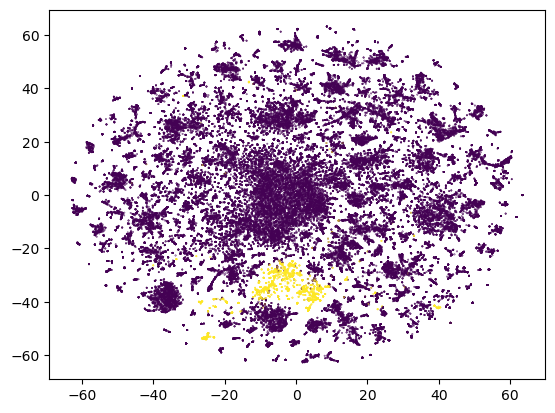

In [65]:
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=0.1, c=db_labels[:, 53].toarray().flatten())
plt.show()

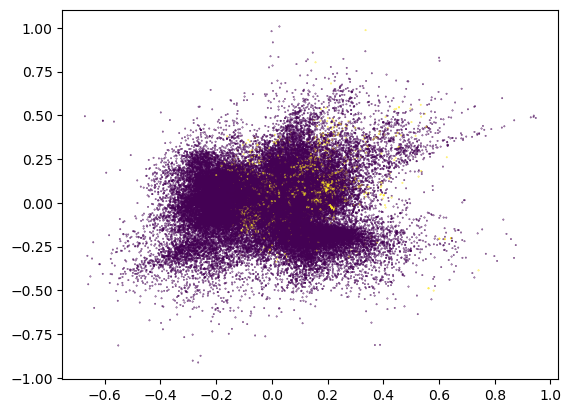

In [62]:
plt.scatter(pca_emb[:, 0], pca_emb[:, 1], s=0.1, c=db_labels[:, 53].toarray().flatten())
plt.show()

In [ ]:
from torch_cluster import knn
from scipy.sparse import csr_matrix
import torch


db_id, q_id = None, None
db_emb, q_emb = None, None

k = 10
matches = knn(db_emb, q_emb, k).cpu().numpy() # 2 x N*K
db_res = matches[1, :]

for i in model_pred.nonzero():
    

def embedding_knn(db_emb, q_emb, db_labels, k=10):
    matches = knn(db_emb, q_emb, k).cpu().numpy() # 2 x N*K
    q_labels = csr_matrix((q_emb.shape[0], db_labels.shape[1]), dtype=float)
    for i in range(q_emb.shape[0]):
        # if(i % 10000 == 0):
        #     print(f"{i/q_emb.shape[0]*100} %")
        db_res = matches[1, i*k:(i+1)*k]
        db_avg = csr_matrix(db_labels[db_res].sum(axis=0) / k)
        q_labels[i] = db_avg
    return q_labels

In [ ]:
collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)